In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats 

from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, fcluster
from sklearn import metrics

import statsmodels.api as sm
import statsmodels.formula.api as smf

import help_funcs as hf

import importlib
import sys

In [2]:
data_to_cluster = pd.read_csv("Данные/processed/clustering-data-v0.csv")
# data_to_cluster.iloc[11]
# data_to_cluster = data_to_cluster.drop([11])
data_to_cluster.head()

,Код раздела,Название раздела,Всего основных фондов,Здания,Машины и оборудование,Сооружения,Транспортные средства
0,A,"Сельское, лесное хозяйство, охота, рыболовство...",1.265974e+07,0.341619,0.326061,0.125921,0.061751
1,B,Добыча полезных ископаемых,4.200038e+07,0.069519,0.185504,0.700053,0.026976
2,C,Обрабатывающие производства,4.013153e+07,0.216858,0.495025,0.231176,0.029704
3,D,"Обеспечение электрической энергией, газом и па...",2.925099e+07,0.156394,0.341688,0.463022,0.011453
4,E,"Водоснабжение; водоотведение, организация сбор...",5.519033e+06,0.122118,0.114837,0.712306,0.036490


In [3]:
outliers_mask = data_to_cluster["Всего основных фондов"] > 0.7 * 10 ** 8
data_to_cluster.insert(0, "is_outlier", outliers_mask)

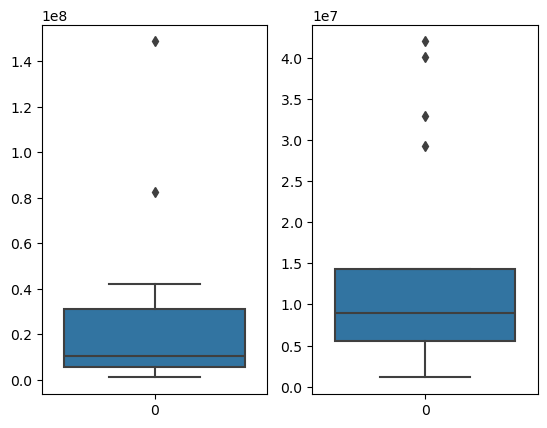

In [4]:
fig, axs = plt.subplots(ncols=2)
sns.boxplot(data_to_cluster['Всего основных фондов'], ax=axs[0])
data_cleared = data_to_cluster[~outliers_mask]
sns.boxplot(data_cleared['Всего основных фондов'], ax=axs[1])
data_to_cluster = data_cleared

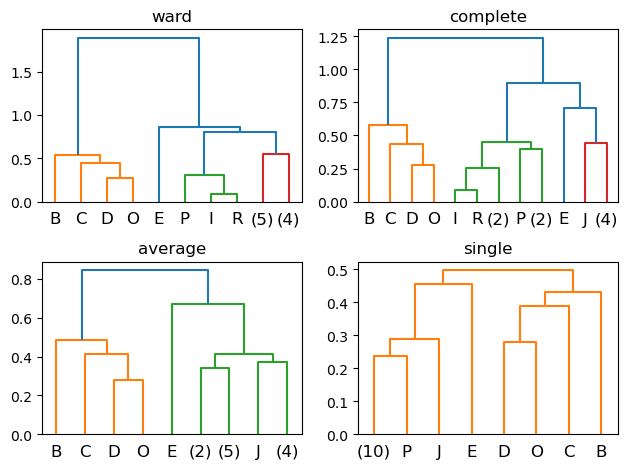

In [5]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)
    return linkage_matrix

X = data_to_cluster.loc[:, "Всего основных фондов":]
scaler = MinMaxScaler()
X["Всего основных фондов"] = scaler.fit_transform(X.loc[:, ["Всего основных фондов"]])

linkage_types = ['ward', 'complete', 'average', 'single']
hclust = dict()
fig, axs = plt.subplots(2, 2)
axs_indices = [(i, j) for i in range(2) for j in range(2)]
for linkage_type, axs_ind in zip(linkage_types, axs_indices):
    clustering = AgglomerativeClustering(linkage=linkage_type, distance_threshold=0, n_clusters=None).fit(X)
    axs[axs_ind].set_title(linkage_type)
    linkage_matrix = plot_dendrogram(
        clustering,
        truncate_mode="level",
        p=3,
        ax=axs[axs_ind], 
        labels=data_to_cluster["Код раздела"].to_list(),
        color_threshold = 0.7
        # orientation='right'
        )
    hclust[linkage_type] = {
        "clustering": clustering,
        "linkage_matrix": linkage_matrix
    }
fig.tight_layout()

In [6]:
T = [0.6, 0.6, 0.6, 0.4]
cluster_mapping = data_to_cluster.loc[:, :"Код раздела"]
for linkage_type, t in zip(linkage_types, T):
    enum = fcluster(hclust[linkage_type]["linkage_matrix"], t=t, criterion='distance')
    model = hclust[linkage_type]["clustering"]
    # hclust[linkage_type]["score"] = metrics.silhouette_score(X, enum, metric='euclidean')
    cluster_mapping[linkage_type] = enum
cluster_mapping.head()

,is_outlier,Код раздела,ward,complete,average,single
0,False,A,3,2,2,1
1,False,B,1,1,1,4
2,False,C,1,1,1,3
3,False,D,1,1,1,3
4,False,E,4,4,3,2


In [7]:
data_clustered = pd.merge(data_to_cluster, cluster_mapping, 'inner', "Код раздела")
data_clustered.to_csv('Данные/processed/clustering-mapping-structure-volume.csv', index=False) 

linkage_type = 'ward'
data_clustered.groupby(linkage_type)["Всего основных фондов"].describe()["mean"]

ward
1    3.609163e+07
2    7.768668e+06
3    7.525403e+06
4    5.519033e+06
Name: mean, dtype: float64

In [8]:
data_for_regr = pd.read_csv('Данные/processed/regression-data-v0.csv')
data_for_regr.head()

,Код раздела,Название раздела,ROFA,K,L,t
0,A,"Сельское, лесное хозяйство, охота, рыболовство...",0.033481,9966787,1.302680e+08,2017
1,A,"Сельское, лесное хозяйство, охота, рыболовство...",0.030218,11231579,1.416755e+08,2018
2,A,"Сельское, лесное хозяйство, охота, рыболовство...",0.031950,10989834,1.516897e+08,2019
3,A,"Сельское, лесное хозяйство, охота, рыболовство...",0.028979,12137603,1.583287e+08,2020
4,A,"Сельское, лесное хозяйство, охота, рыболовство...",0.024977,13966128,1.770949e+08,2021


In [9]:
data_for_regr_cl = pd.merge(data_for_regr, cluster_mapping, 'inner', "Код раздела")
data_for_regr_cl.loc[:, "ROFA":"t"] = data_for_regr_cl.loc[:, "ROFA":"t"].apply(lambda x: np.log(x))
data_for_regr_cl = data_for_regr_cl.rename(columns={"ROFA": "ln_ROFA", "K": "ln_K", "L": "ln_L"})

C:\Users\brazen\AppData\Local\Temp\ipykernel_15352\2708409770.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[16.11476882 16.23423992 16.21248122 16.31181888 16.45214553 16.68718188
 17.23566792 17.34743297 17.51370744 17.58574375 17.64371821 17.8671868
 17.18359907 17.29756733 17.41037783 17.52189768 17.60621222 17.87310161
 16.80179449 16.96066961 17.11410137 17.24368435 17.3197276  17.53686848
 15.45967854 15.50873836 15.36863079 15.45051504 15.56747476 15.74396989
 14.99203436 15.11098375 15.32165936 15.32777656 15.43598356 15.70258339
 15.53112162 15.67127137 15.77998573 15.8302505  15.85090734 16.11217828
 14.56586098 14.62178551 14.64534321 14.70772087 15.05524936 15.1732524
 15.70460074 15.86885206 15.92332549 16.0409191  16.09187867 16.30319759
 15.17535596 15.39237838 15.48247408 15.70714115 15.8144243  16.02730284
 16.05521272 16.15671859 16.08502251 15.99790561 16.23674107 16.35199159
 14.8255335  

In [10]:
data_test = data_for_regr_cl[data_for_regr_cl["Код раздела"] == 'A']
X = data_test.loc[:, ["ln_K", "ln_L", "t"]].reset_index(drop=True)
X = sm.add_constant(X)
Y = data_test.loc[:, ["ln_ROFA"]].reset_index(drop=True)
regression = sm.OLS(Y, X, hasconst=True)
result_OLS = regression.fit()


importlib.reload(hf)
ar1_regr = hf.OLSAR1(regression)
print(ar1_regr.model.exog)
print(ar1_regr.model.endog)
ar1_regr.summary()

Rho =  -0.8459372882580015
Rho =  -0.8778319890890305
Rho =  -0.8781958516414359
Rho =  -0.8781937081372106
[[ 0.47830514  7.70777683  8.93718156  3.63959916]
 [ 1.87819371 30.38612851 35.17819079 14.29236002]
 [ 1.87819371 30.46928858 35.32020858 14.29329072]
 [ 1.87819371 30.54951788 35.42302347 14.29422097]
 [ 1.87819371 30.77708223 35.57265475 14.29515075]
 [ 1.87819371 31.13535257 35.83615543 14.29608008]]
[-1.62470157 -6.4823669  -6.5166837  -6.56531663 -6.79962346 -7.10078613]


c:\Users\brazen\Miniconda3\envs\ds\Lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 6 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          1.441e+06
Date:                Wed, 06 Mar 2024   Prob (F-statistic):                    6.94e-07
Time:                        18:14:00   Log-Likelihood:                          25.210
No. Observations:                   6   AIC:                                     -42.42
Df Residuals:                       2   BIC:                                     -43.25
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1           336.1324    133.940      2.510      0.129    -240.166     912.430
x2            -1.4286      0.097    -14.762      0.005      -1.845      -1.012
x3             0.9375      0.204      4.604      0.044       0.061       1.814
x4           -43.8958     17.911     -2.451      0.134    -120.962      33.170
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   3.656
Prob(Omnibus):                    nan   Jarque-Bera (JB):                0.474
Skew:                           0.175   Prob(JB):                        0.789
Kurtosis:                       1.669   Cond. No.                     2.38e+06
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 2.38e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [12]:
for cluster_id in data_for_regr_cl[linkage_type].unique():
    cluster = data_for_regr_cl[data_for_regr_cl[linkage_type] == cluster_id]
    labels = cluster["Код раздела"]
    X = cluster.loc[:, ["ln_K", "ln_L", "t"]].reset_index(drop=True)
    X = sm.add_constant(X)
    Y = cluster.loc[:, ["ln_ROFA"]].reset_index(drop=True)
    regression = sm.OLS(Y, X, hasconst=True)
    result_OLS = regression.fit()

    print('\nLinkage: {l}, cluster {c}, n: {n}'.format(l=linkage_type, c=cluster_id, n=X[X.columns[0]].count()))
    print(result_OLS.summary())
    white_pvalue = sm.stats.diagnostic.het_white(result_OLS.resid, X)[1]
    print('-- White\'s test pvalue: ', white_pvalue)

    # importlib.reload(hf)
    # ar1_regr = hf.OLSAR1_panel_flat(regression, labels)
    # ar1_regr.summary()
    
    # X_resid = X.iloc[:, 1:]
    # X_resid = X_resid.join(pd.DataFrame({"e": result_OLS.resid}))
    # g = sns.PairGrid(X_resid, y_vars=["e"], x_vars=["ln_K", "ln_L", "t"], height=4)
    # g.map(sns.regplot, color=".3", ci=None)
    # g.set(ylim=(-1.5, 1.5), yticks=[-1.5, -1, 0, 1, 1.5])


Linkage: ward, cluster 3, n: 48
                            OLS Regression Results                            
Dep. Variable:                ln_ROFA   R-squared:                       0.908
Model:                            OLS   Adj. R-squared:                  0.902
Method:                 Least Squares   F-statistic:                     144.5
Date:                Wed, 06 Mar 2024   Prob (F-statistic):           8.51e-23
Time:                        18:14:54   Log-Likelihood:                 6.2101
No. Observations:                  48   AIC:                            -4.420
Df Residuals:                      44   BIC:                             3.065
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        490.55

c:\Users\brazen\Miniconda3\envs\ds\Lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 6 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
c:\Users\brazen\Miniconda3\envs\ds\Lib\site-packages\scipy\stats\_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [ ]:
groups = data_for_regr_cl.groupby(by="Код раздела", as_index=False)
for name, group in groups:
    print(group)

  Код раздела                                   Название раздела   ln_ROFA  \
0           A  Сельское, лесное хозяйство, охота, рыболовство... -3.396789   
1           A  Сельское, лесное хозяйство, охота, рыболовство... -3.499328   
2           A  Сельское, лесное хозяйство, охота, рыболовство... -3.443596   
3           A  Сельское, лесное хозяйство, охота, рыболовство... -3.541173   
4           A  Сельское, лесное хозяйство, охота, рыболовство... -3.689788   
5           A  Сельское, лесное хозяйство, охота, рыболовство... -3.860438   

        ln_K       ln_L         t  ward  complete  average  single  
0  16.114769  18.685104  7.609367     3         2        1       1  
1  16.234240  18.769050  7.609862     3         2        1       1  
2  16.212481  18.837347  7.610358     3         2        1       1  
3  16.311819  18.880184  7.610853     3         2        1       1  
4  16.452146  18.992196  7.611348     3         2        1       1  
5  16.687182  19.157328  7.611842     3

In [ ]:
data_for_ANOVA = pd.merge(cluster_mapping, data_for_regr.loc[:, ["Код раздела", "ROFA"]], 'inner', 'Код раздела')
for linkage_type in linkage_types:
    groups = []
    for group_id in data_for_ANOVA[linkage_type].unique():
        groups.append(data_for_ANOVA["ROFA"][(data_for_ANOVA[linkage_type] == group_id)].to_numpy())
    res = stats.bartlett(*groups)
    print('bartlett', res.pvalue)
    res = stats.kruskal(*groups)
    print('kruskal', res.pvalue)

bartlett 8.065545418041749e-15
kruskal 2.1106469870207733e-08
bartlett 8.065545418041749e-15
kruskal 2.1106469870207733e-08
bartlett 3.0243762031726055e-20
kruskal 1.6512227527268064e-12
bartlett 7.852880291599407e-05
kruskal 0.0005957626838300733
